In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from torchvision import datasets
import torchvision.utils as utils
import torchvision.transforms as transforms
from torchvision.io import read_image
from pathlib import Path
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import PIL
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u '/content/drive/MyDrive/real_accuracy.zip' -d '/content/data1'

from IPython. display import clear_output
clear_output()

**creating a csv file with names of all images**

In [ ]:
import os
import csv

# Replace "folder_path" with the path to the folder you want to list files from
folder_path = "/content/data1/real_accuracy"

# Get a list of all files in the folder
file_names = os.listdir(folder_path)

# Create a new CSV file called "file_names.csv"
with open("annotations1.csv", "w") as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write a header row to the CSV file
    csv_writer.writerow(["image",'label'])

    # Write the name of each file to a new row in the CSV file
    for file_name in file_names:
        csv_writer.writerow([file_name,1])
        

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [ ]:
data1=CustomImageDataset('/content/annotations1.csv','/content/data1/real_accuracy',
                        transform=transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(64),
                        transforms.CenterCrop(256),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ]))

len(data1)

1182

In [ ]:
train_data1,test_data1=torch.utils.data.random_split(data1,[950,232])

train_loader1=DataLoader(train_data1, batch_size=32, shuffle=True)
test_loader1=DataLoader(test_data1, batch_size=32, shuffle=True)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
learning_rate1=1e-4

num_epochs1=10
nc=3
ndf=64
batch_size=32

# Model1 for real image classification

In [ ]:
class AccuracyCheck1(nn.Module):
    def __init__(self):
        super(AccuracyCheck1,self).__init__()

        self.m=nn.Softmax(dim=1)

        self.maxpool=nn.MaxPool2d(2,2)

        self.conv1=nn.Conv2d(3,32,2) 
        self.conv2=nn.Conv2d(32,64,2)
        self.conv3=nn.Conv2d(64,128,2)
        self.conv4=nn.Conv2d(128,50,2)
        self.conv5=nn.Conv2d(50,20,2)

        self.fc1=nn.Linear(20*7*7,10)
        self.fc2=nn.Linear(10,3)

    def forward(self, x):
        x=self.maxpool(F.relu(self.conv1(x)))
        x=self.maxpool(F.relu(self.conv2(x)))
        x=self.maxpool(F.relu(self.conv3(x)))
        x=self.maxpool(F.relu(self.conv4(x)))
        x=self.maxpool(F.relu(self.conv5(x)))

        x=x.view(-1, 20*7*7)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x=self.m(x)

        return x

In [ ]:
model1=AccuracyCheck1().to(device)

In [ ]:
optimizer1=torch.optim.Adam(model1.parameters(),lr=learning_rate1)

In [ ]:
def criterion1(y_pred,y):
    v=-(y*torch.log(y_pred+1e-5))
    v=torch.sum(v)
    return v

In [ ]:
x,y=train_data1[2]
print('input size: ',x.shape)

x=x.to(device)
output=model1(x)
#print('output size: ',output.shape)

print('output: ',output)
print('y: ',y)


loss=criterion1(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output:  tensor([[0.3119, 0.3945, 0.2936]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
y:  1
loss value:  3.320631980895996


In [ ]:
import os

directory = "/content/data1/real_accuracy"
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    if os.path.isfile(file_path):
        file_extension = os.path.splitext(file_path)[1]
        if(file_extension=='.png' or file_extension=='.jpg'):
            continue
        else:
            print(file_extension)

In [ ]:
n_total_steps=len(train_loader1)
print(n_total_steps)


30


In [ ]:
def train_network1(train_loader,optimizer,criterion,num_epochs):
      for epoch in range(num_epochs):
            train_loss=0.0

            for i,data in enumerate(train_loader,0):
                images,labels=data
                images=images.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                outputs=model1(images)
                #print(outputs.shape,labels.shape)

                onehot=torch.nn.functional.one_hot(labels,num_classes=3)
                # print(outputs)
                # print(onehot)
          
                #loss function
                loss=criterion(outputs,onehot)
                loss.backward()    #finding the derivative of loss function wrt to coefficients

                optimizer.step()        #calulating the gradients

                train_loss+=loss

                #print statistics
                if((i+1)%30==0):
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {train_loss:.4f}')

In [ ]:
train_network1(train_loader1,optimizer1,criterion1,num_epochs1)

Epoch [1/10], Step [30/30], Loss: 872.8134
Epoch [2/10], Step [30/30], Loss: 656.2131
Epoch [3/10], Step [30/30], Loss: 52.4124
Epoch [4/10], Step [30/30], Loss: 0.3591
Epoch [5/10], Step [30/30], Loss: 0.1531
Epoch [6/10], Step [30/30], Loss: 0.1115
Epoch [7/10], Step [30/30], Loss: 0.0840
Epoch [8/10], Step [30/30], Loss: 0.0634
Epoch [9/10], Step [30/30], Loss: 0.0429
Epoch [10/10], Step [30/30], Loss: 0.0236


In [ ]:
def test_model1(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=3)

            outputs=model(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_model1(test_loader1,model1,criterion1)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


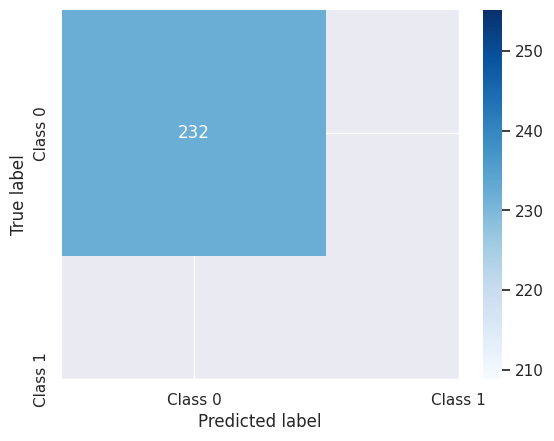

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Model3 for real images

In [ ]:
class AccuracyCheck3(nn.Module):
    def __init__(self):
        super(AccuracyCheck3,self).__init__()

        self.m=nn.Softmax(dim=1)

        self.fc1=nn.Linear(3*256*256,100)
        self.fc2=nn.Linear(100,10)
        self.fc3=nn.Linear(10,3)

    def forward(self, x):
        x=x.view(-1,3*256*256)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x=self.m(x)

        return x

In [ ]:
learning_rate3=3e-4
model3=AccuracyCheck3().to(device)

In [ ]:
optimizer3=torch.optim.Adam(model3.parameters(),lr=learning_rate3)

In [ ]:
x,y=train_data1[2]
print('input size: ',x.shape)

x=x.to(device)
output=model3(x)
#print('output size: ',output.shape)

print('output: ',output)
print('y: ',y)


loss=criterion1(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output:  tensor([[0.3858, 0.3598, 0.2545]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
y:  1
loss value:  3.3433244228363037


In [ ]:
def train_network3(train_loader,optimizer,criterion,num_epochs):
      for epoch in range(num_epochs):
            train_loss=0.0

            for i,data in enumerate(train_loader,0):
                images,labels=data
                images=images.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                outputs=model3(images)
                #print(outputs.shape,labels.shape)
                #print(outputs)

                onehot=torch.nn.functional.one_hot(labels,num_classes=3)
                # print(outputs)
                # print(onehot)
          
                #loss function
                loss=criterion(outputs,onehot)
                loss.backward()    #finding the derivative of loss function wrt to coefficients

                optimizer.step()        #calulating the gradients

                train_loss+=loss

                #print statistics
                if((i+1)%30==0):
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {train_loss:.4f}')

In [ ]:
train_network3(train_loader1,optimizer3,criterion1,num_epochs1)

Epoch [1/10], Step [30/30], Loss: 61.9471
Epoch [2/10], Step [30/30], Loss: -0.0095
Epoch [3/10], Step [30/30], Loss: -0.0095
Epoch [4/10], Step [30/30], Loss: -0.0095
Epoch [5/10], Step [30/30], Loss: -0.0095
Epoch [6/10], Step [30/30], Loss: -0.0095
Epoch [7/10], Step [30/30], Loss: -0.0095
Epoch [8/10], Step [30/30], Loss: -0.0095
Epoch [9/10], Step [30/30], Loss: -0.0095
Epoch [10/10], Step [30/30], Loss: -0.0095


In [ ]:
def test_model3(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=3)

            outputs=model3(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_model3(test_loader1,model3,criterion1)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


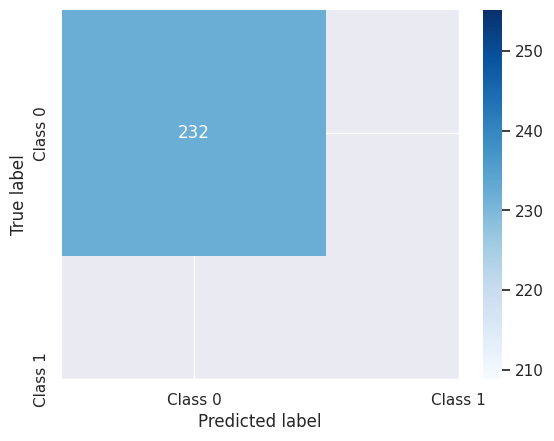

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#Ensemble model for real images

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self,modelA,modelB):
        super(EnsembleModel, self).__init__()
        
        self.modelA = modelA
        self.modelB = modelB
        #self.modelC = modelC

        self.fc = nn.Linear(6,2)
    
    def forward(self, x):
        outA = self.modelA(x)
        outB = self.modelB(x)
        #outC = self.modelC(x)

        out = torch.cat((outA, outB), dim=1)
        out = self.fc(out)
        return out

In [ ]:
model_ar=AccuracyCheck1().to(device)
model_br=AccuracyCheck3().to(device)
#model_c=AccuracyCheck3().to(device)

In [ ]:
ensemble = EnsembleModel(model_ar,model_br).to(device)

In [ ]:
optimizer = torch.optim.SGD(ensemble.parameters(), lr=0.01)

In [ ]:
train_data,test_data=torch.utils.data.random_split(data1,[950,232])

train_loader=DataLoader(train_data1, batch_size=32, shuffle=True)
test_loader=DataLoader(test_data1, batch_size=32, shuffle=True)

In [ ]:
import math

def lossFunction(y_pred,y):
    y_pred[y_pred<0]=-y_pred[y_pred<0]

    v=-(y*torch.log(y_pred+0.0001))
    v=torch.sum(v)
    return v

In [ ]:
x,y=train_data[19]
print('input size: ',x.shape)

x=x.to(device)

output=ensemble(x)
print('output size: ',output.shape)
print('output: ',output)
print('y: ',y)

y= np.array([y])
y=torch.from_numpy(y)
y=y.to(device)

loss=lossFunction(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output size:  torch.Size([1, 2])
output:  tensor([[-0.0732,  0.3023]], device='cuda:0', grad_fn=<AddmmBackward0>)
y:  1
loss value:  3.809448719024658


In [ ]:
steps=len(train_loader)
steps

30

In [ ]:
def train_real(model,optimizer,criterion,train_loader,num_epochs):
    model.train()
    train_loss=0.0
    
    for epoch in range(num_epochs):
        for i,data in enumerate(train_loader,0):
            images,labels=data
            
            images=images.to(device)
            labels=labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            #print(outputs.shape,labels.shape)

            onehot=torch.nn.functional.one_hot(labels,num_classes=2)

            loss = criterion(outputs,onehot)
            train_loss+=loss

            loss.backward()
            optimizer.step()

            #print statistics
            if((i+1)%25==0):
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{steps}], Loss: {train_loss:.4f}')

In [ ]:
train_real(ensemble,optimizer,lossFunction,train_loader,num_epochs=50)

Epoch [1/50], Step [25/30], Loss: -1116.9105
Epoch [2/50], Step [25/30], Loss: -3101.4822
Epoch [3/50], Step [25/30], Loss: -5376.8291
Epoch [4/50], Step [25/30], Loss: -7838.1294
Epoch [5/50], Step [25/30], Loss: -10432.0664
Epoch [6/50], Step [25/30], Loss: -13129.3955
Epoch [7/50], Step [25/30], Loss: -15911.5029
Epoch [8/50], Step [25/30], Loss: -18765.4922
Epoch [9/50], Step [25/30], Loss: -21681.8633
Epoch [10/50], Step [25/30], Loss: -24653.3672
Epoch [11/50], Step [25/30], Loss: -27674.2441
Epoch [12/50], Step [25/30], Loss: -30739.8398
Epoch [13/50], Step [25/30], Loss: -33846.2891
Epoch [14/50], Step [25/30], Loss: -36990.3594
Epoch [15/50], Step [25/30], Loss: -40169.2891
Epoch [16/50], Step [25/30], Loss: -43380.6680
Epoch [17/50], Step [25/30], Loss: -46622.4570
Epoch [18/50], Step [25/30], Loss: -49892.8047
Epoch [19/50], Step [25/30], Loss: -53190.0820
Epoch [20/50], Step [25/30], Loss: -56512.8555
Epoch [21/50], Step [25/30], Loss: -59859.8164
Epoch [22/50], Step [25/30

In [ ]:
def test_real(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=2)

            outputs=model(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_real(test_loader,ensemble,lossFunction)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


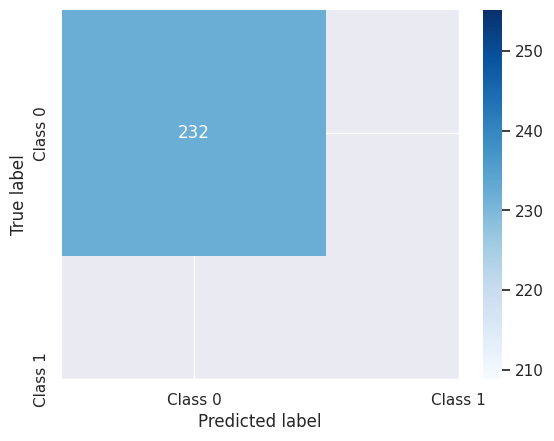

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Model for fake images


In [ ]:
!unzip -u '/content/drive/MyDrive/fakes_accuracy.zip' -d '/content/data2'

from IPython. display import clear_output
clear_output()

In [ ]:
import os
import csv

# Replace "folder_path" with the path to the folder you want to list files from
folder_path = "/content/data2/fakes_accuracy"

# Get a list of all files in the folder
file_names = os.listdir(folder_path)

# Create a new CSV file called "file_names.csv"
with open("annotations2.csv", "w") as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write a header row to the CSV file
    csv_writer.writerow(["image",'label'])

    # Write the name of each file to a new row in the CSV file
    for file_name in file_names:
        csv_writer.writerow([file_name,0])
        

In [ ]:
data2=CustomImageDataset('/content/annotations2.csv','/content/data2/fakes_accuracy',
                        transform=transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(64),
                        transforms.CenterCrop(256),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ]))

len(data2)

9472

In [ ]:
train_data2,test_data2=torch.utils.data.random_split(data2,[7672,1800])

train_loader2=DataLoader(train_data2, batch_size=32, shuffle=True)
test_loader2=DataLoader(test_data2, batch_size=32, shuffle=True)

In [ ]:
learning_rate2=1e-4
num_epochs2=10

In [ ]:
class AccuracyCheck2(nn.Module):
    def __init__(self):
        super(AccuracyCheck2,self).__init__()

        self.m=nn.Softmax(dim=1)

        self.maxpool=nn.MaxPool2d(2,2)

        self.conv1=nn.Conv2d(3,32,2) 
        self.conv2=nn.Conv2d(32,64,2)
        self.conv3=nn.Conv2d(64,128,2)
        self.conv4=nn.Conv2d(128,50,2)

        self.fc1=nn.Linear(50*15*15,10)
        self.fc2=nn.Linear(10,3)

    def forward(self, x):
        x=self.maxpool(F.relu(self.conv1(x)))
        x=self.maxpool(F.relu(self.conv2(x)))
        x=self.maxpool(F.relu(self.conv3(x)))
        x=self.maxpool(F.relu(self.conv4(x)))

        x=x.view(-1, 50*15*15)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x=self.m(x)

        return x

In [ ]:
model2=AccuracyCheck2().to(device)

In [ ]:
optimizer2=torch.optim.Adam(model2.parameters(),lr=learning_rate2)

In [ ]:
x,y=train_data2[210]
print('input size: ',x.shape)

x=x.to(device)
output=model2(x)
#print('output size: ',output.shape)

print('output: ',output)
print('y: ',y)


loss=criterion1(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output:  tensor([[0.3443, 0.3912, 0.2645]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
y:  0
loss value:  0.0


In [ ]:
import os

directory = "/content/data2/fakes_accuracy"
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    if os.path.isfile(file_path):
        file_extension = os.path.splitext(file_path)[1]
        if(file_extension=='.png' or file_extension=='.jpg'):
            continue
        else:
            print(file_extension)

In [ ]:
n_total_steps=len(train_loader2)
n_total_steps

240

In [ ]:
def train_network2(train_loader,optimizer,criterion,num_epochs):
      for epoch in range(num_epochs):
            train_loss=0.0

            for i,data in enumerate(train_loader,0):
                images,labels=data
                images=images.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                outputs=model2(images)
                #print(outputs.shape,labels.shape)
                #print(outputs)

                onehot=torch.nn.functional.one_hot(labels,num_classes=3)
                # print(outputs)
                # print(onehot)
          
                #loss function
                loss=criterion(outputs,onehot)
                loss.backward()    #finding the derivative of loss function wrt to coefficients

                optimizer.step()        #calulating the gradients

                train_loss+=loss

                #print statistics
                if((i+1)%200==0):
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {train_loss:.4f}')

In [ ]:
train_network2(train_loader2,optimizer2,criterion1,num_epochs2)

Epoch [1/10], Step [200/240], Loss: 682.5041
Epoch [2/10], Step [200/240], Loss: -0.0596
Epoch [3/10], Step [200/240], Loss: -0.0624
Epoch [4/10], Step [200/240], Loss: -0.0633
Epoch [5/10], Step [200/240], Loss: -0.0636
Epoch [6/10], Step [200/240], Loss: -0.0641
Epoch [7/10], Step [200/240], Loss: -0.0641
Epoch [8/10], Step [200/240], Loss: -0.0641
Epoch [9/10], Step [200/240], Loss: -0.0641
Epoch [10/10], Step [200/240], Loss: -0.0641


In [ ]:
def test_model2(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=3)

            outputs=model(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_model2(test_loader2,model2,criterion1)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


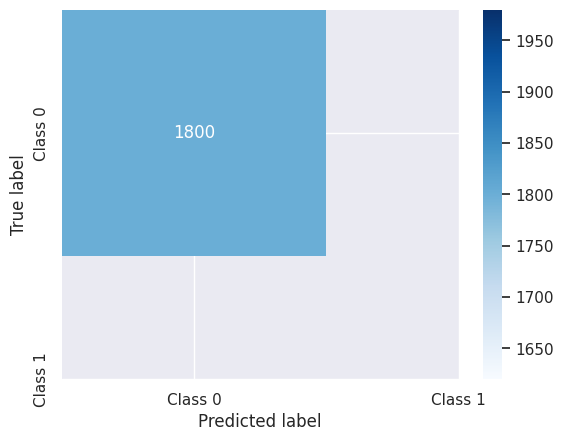

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Model4 for fake images

In [ ]:
model4=AccuracyCheck3().to(device)
learning_rate4=2e-4

In [ ]:
optimizer4=torch.optim.Adam(model4.parameters(),lr=learning_rate4)

In [ ]:
x,y=train_data2[210]
print('input size: ',x.shape)

x=x.to(device)
output=model2(x)
#print('output size: ',output.shape)

print('output: ',output)
print('y: ',y)


loss=criterion1(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output:  tensor([[1.0000e+00, 4.5183e-08, 6.5519e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
y:  0
loss value:  0.0


In [ ]:
def train_network4(train_loader,optimizer,criterion,num_epochs):
      for epoch in range(num_epochs):
            train_loss=0.0

            for i,data in enumerate(train_loader,0):
                images,labels=data
                images=images.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                outputs=model4(images)
                #print(outputs.shape,labels.shape)
                #print(outputs)

                onehot=torch.nn.functional.one_hot(labels,num_classes=3)
                # print(outputs)
                # print(onehot)
          
                #loss function
                loss=criterion(outputs,onehot)
                loss.backward()    #finding the derivative of loss function wrt to coefficients

                optimizer.step()        #calulating the gradients

                train_loss+=loss

                #print statistics
                if((i+1)%200==0):
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {train_loss:.4f}')

In [ ]:
train_network4(train_loader2,optimizer4,criterion1,num_epochs2)

Epoch [1/10], Step [200/240], Loss: 188.2401
Epoch [2/10], Step [200/240], Loss: -0.0641
Epoch [3/10], Step [200/240], Loss: -0.0641
Epoch [4/10], Step [200/240], Loss: -0.0641
Epoch [5/10], Step [200/240], Loss: -0.0641
Epoch [6/10], Step [200/240], Loss: -0.0641
Epoch [7/10], Step [200/240], Loss: -0.0641
Epoch [8/10], Step [200/240], Loss: -0.0641
Epoch [9/10], Step [200/240], Loss: -0.0641
Epoch [10/10], Step [200/240], Loss: -0.0641


In [ ]:
def test_model4(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=3)

            outputs=model(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_model4(test_loader2,model4,criterion1)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


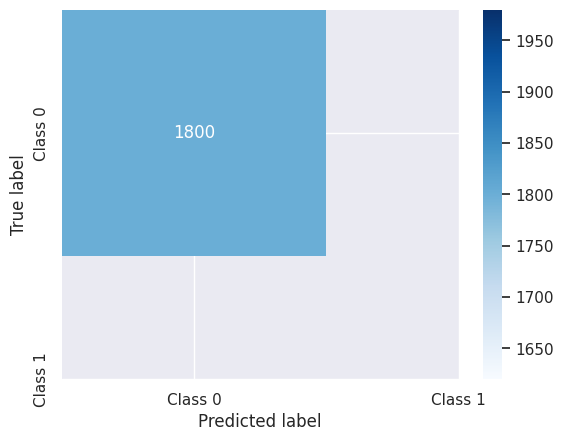

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Ensemble model for fakes


In [ ]:
model_af=AccuracyCheck2().to(device)
model_bf=AccuracyCheck3().to(device)
#model_c=AccuracyCheck3().to(device)

In [ ]:
ensemble_fake = EnsembleModel(model_af,model_bf).to(device)

In [ ]:
optimizer_fake = torch.optim.SGD(ensemble_fake.parameters(), lr=0.01)

In [ ]:
train_data,test_data=torch.utils.data.random_split(data2,[7672,1800])

train_loader=DataLoader(train_data, batch_size=32, shuffle=True)
test_loader=DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
x,y=train_data[19]
print('input size: ',x.shape)

x=x.to(device)

output=ensemble(x)
print('output size: ',output.shape)
print('output: ',output)
print('y: ',y)

y= np.array([y])
y=torch.from_numpy(y)
y=y.to(device)

loss=lossFunction(output, y)
print('loss value: ',loss.item())

input size:  torch.Size([3, 256, 256])
output size:  torch.Size([1, 2])
output:  tensor([[-0.1780, 53.2967]], device='cuda:0', grad_fn=<AddmmBackward0>)
y:  0
loss value:  0.0


In [ ]:
steps=len(train_loader)
steps

240

In [ ]:
def train_fake(model,optimizer,criterion,train_loader,num_epochs):
    model.train()
    train_loss=0.0
    
    for epoch in range(num_epochs):
        for i,data in enumerate(train_loader,0):
            images,labels=data
            
            images=images.to(device)
            labels=labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            #print(outputs.shape,labels.shape)

            onehot=torch.nn.functional.one_hot(labels,num_classes=2)

            loss = criterion(outputs,onehot)
            train_loss+=loss

            loss.backward()
            optimizer.step()

            #print statistics
            if((i+1)%100==0):
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{steps}], Loss: {train_loss:.4f}')

In [ ]:
train_fake(ensemble,optimizer,lossFunction,train_loader,num_epochs=50)

Epoch [1/50], Step [100/240], Loss: -7411.5776
Epoch [1/50], Step [200/240], Loss: -16601.8184
Epoch [2/50], Step [100/240], Loss: -30678.4512
Epoch [2/50], Step [200/240], Loss: -41325.1211
Epoch [3/50], Step [100/240], Loss: -56782.6562
Epoch [3/50], Step [200/240], Loss: -68175.7812
Epoch [4/50], Step [100/240], Loss: -84477.9844
Epoch [4/50], Step [200/240], Loss: -96377.6172
Epoch [5/50], Step [100/240], Loss: -113290.9141
Epoch [5/50], Step [200/240], Loss: -125574.5547
Epoch [6/50], Step [100/240], Loss: -142966.9688
Epoch [6/50], Step [200/240], Loss: -155560.0156
Epoch [7/50], Step [100/240], Loss: -173346.7969
Epoch [7/50], Step [200/240], Loss: -186198.9531
Epoch [8/50], Step [100/240], Loss: -204320.7656
Epoch [8/50], Step [200/240], Loss: -217395.8594
Epoch [9/50], Step [100/240], Loss: -235808.9844
Epoch [9/50], Step [200/240], Loss: -249079.7344
Epoch [10/50], Step [100/240], Loss: -267750.4688
Epoch [10/50], Step [200/240], Loss: -281195.5000
Epoch [11/50], Step [100/24

In [ ]:
def test_fake(test_loader,model,criterion):

    model.eval()
    test_loss,correct=0,0
    num_batches=len(test_loader)
    size=len(test_loader.dataset)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in test_loader:
            X=X.to(device)
            y=y.to(device)
            tmp=torch.nn.functional.one_hot(y,num_classes=2)

            outputs=model(X)

            test_loss=test_loss+criterion(outputs,tmp).item()
            pred = outputs.argmax(dim=1, keepdim=True)

            correct += pred.eq(y.view_as(pred)).sum().item()

            y_true.extend(y.tolist())
            y_pred.extend(pred.view_as(y).tolist())
            
    test_loss=test_loss/num_batches
    correct=correct/size

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy,precision,recall,f1,cm

In [ ]:
a,p,r,f1,cm=test_fake(test_loader,ensemble,lossFunction)

print(f'accuracy: {a:.4f}')
print(f'precision: {p:.4f}')
print(f'recall: {r:.4f}')
print(f'F1 score: {f1:.4f}')

accuracy: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000


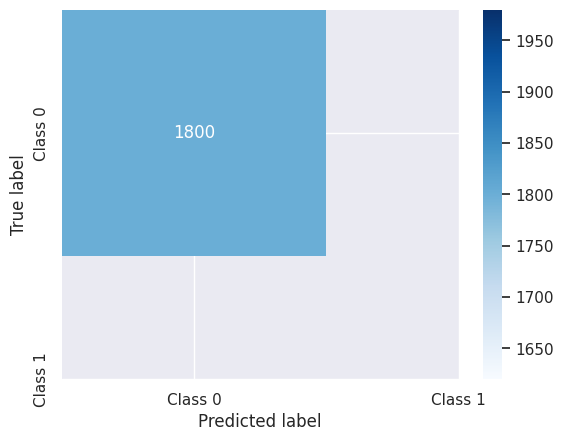

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()